# Models

This notebook looks at the controlled products and top products in DCD

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import datetime as dt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from xgboost import XGBRegressor

# Read in Products Data

In [2]:
products = pd.read_csv('../data/clean_data/products_clean.csv', compression='zip', parse_dates=True, index_col='date')
products.head()

,territory,ar_div,customer_num,sold_to_name,item_num,item_description,item_type,unit_of_measure,weight,standard_price,quantity,price,year,month
date,,,,,,,,,,,,,,
2017-01-01,EB,0,1000026,Monterey Foods Market,039675777771,Have'a Corn Chips,CHIPS,EACH,4 oz,1.90,48.0,76.80,2017,1
2017-01-01,SF,0,1007292,Madera Liquor,039675777771,Have'a Corn Chips,CHIPS,EACH,4 oz,1.90,12.0,19.20,2017,1
2017-01-01,MR,0,1000282,Mollie Stone #1-Sausalito,704108725215,Casa Linda Enchilada Sauce,SAUCE,EACH,24 oz,3.51,12.0,42.12,2017,1
2017-01-01,SF,0,1007262,KD's Grog & Grocery,070415101562,Benzels Pennystick Rods,CHIPS,EACH,12 oz,1.81,6.0,10.86,2017,1
2017-01-01,SF,0,1007262,KD's Grog & Grocery,039675777771,Have'a Corn Chips,CHIPS,EACH,4 oz,1.90,6.0,9.60,2017,1


In [3]:
# filter to only use certain columns
cols = [
    'territory',
    'sold_to_name',
    'item_description',
    'item_type',
    'standard_price',
    'quantity',
    'price'
]

# apply column filter
products = products[cols]
products.head()

,territory,sold_to_name,item_description,item_type,standard_price,quantity,price
date,,,,,,,
2017-01-01,EB,Monterey Foods Market,Have'a Corn Chips,CHIPS,1.90,48.0,76.80
2017-01-01,SF,Madera Liquor,Have'a Corn Chips,CHIPS,1.90,12.0,19.20
2017-01-01,MR,Mollie Stone #1-Sausalito,Casa Linda Enchilada Sauce,SAUCE,3.51,12.0,42.12
2017-01-01,SF,KD's Grog & Grocery,Benzels Pennystick Rods,CHIPS,1.81,6.0,10.86
2017-01-01,SF,KD's Grog & Grocery,Have'a Corn Chips,CHIPS,1.90,6.0,9.60


In [4]:
# list of all store names
stores = list(set(products['sold_to_name']))

In [5]:
# create dataframe of territory and store names
df_territories = products[['territory', 'sold_to_name']]
df_territories.drop_duplicates(inplace=True)

# convert dataframe to a dictionary
dict_territories = df_territories.to_dict(orient='records')

# instantiate empty dictionary
territories = {}

# loop through the dictionary of territories and restructure it
for territory in dict_territories:
    territories[territory['sold_to_name']] = territory['territory']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Read in RFM Data

In [6]:
rfm = pd.read_csv('../data/clean_data/stores_segmented.csv', compression='zip')
rfm.head()

,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3
0,17th & Balboa Market,58.8,1,74.87,4,4,4,444,12,2
1,17th & Cole Market,5.1,44,2997.60,3,2,3,323,8,0
2,25th & Clement Produce,0.0,58,12919.35,1,2,2,122,5,0
3,300 Church St. Market,0.0,60,13191.46,1,2,2,122,5,0
4,3rd Ave Food Market,53.8,5,753.99,4,4,3,443,11,2


In [7]:
# select only the store name and label and create a dictionary of them
store_labels = rfm[['sold_to_name', 'labels3']]
store_labels = store_labels.to_dict(orient='records')

In [8]:
# resture the dictionary to have key, value pairs of the store and label
labels = {}

for label in store_labels:
    labels[label['sold_to_name']] = label['labels3']

In [9]:
# map the labels to the products dataset 
products['label'] = products['sold_to_name'].map(labels)

In [10]:
products['label'].value_counts(dropna=False)

0.0    256185
1.0     15474
2.0       991
NaN        13
Name: label, dtype: int64

In [11]:
products[products['label'].isna()]

,territory,sold_to_name,item_description,item_type,standard_price,quantity,price,label
date,,,,,,,,
2019-03-01,SF,KT Liquors,Dolcetto Hazelnut Rolled Wafer,COOKIE,1.85,4.0,7.00,NaN
2019-03-01,SF,KT Liquors,Dolcetto Rosemary & Olive Oil,CRACKER,2.70,4.0,10.40,NaN
2019-03-01,SF,KT Liquors,Chocolate Fusion Dark Choc,COOKIE,1.30,4.0,4.60,NaN
2019-03-01,SF,KT Liquors,Chocolate Fusion Milk Choc,COOKIE,1.30,4.0,4.60,NaN
2019-03-01,SF,KT Liquors,Loacker Cappuccino,COOKIE,3.95,4.0,15.80,NaN
2019-03-01,SF,KT Liquors,King Henry Sunflower Kernels,SNACK,1.39,6.0,8.34,NaN
2019-03-01,SF,KT Liquors,King Henry Pumpkin Seeds,SNACK,1.39,6.0,8.34,NaN
2019-03-01,SF,KT Liquors,King Henry Almonds Smkd,NUTS,1.39,6.0,8.34,NaN
2019-03-01,SF,KT Liquors,Benzels Pennystick Rods,CHIPS,1.91,6.0,10.86,NaN


In [12]:
# drop the missing values
products.dropna(inplace=True)

In [13]:
# filter the rfm dataframe to only have the stores in the products dataframe
rfm_stores = rfm[rfm['sold_to_name'].isin(stores)]
rfm_stores["monetary_log"] = np.log(rfm_stores["monetary"])
rfm_stores['territory'] = rfm_stores['sold_to_name'].map(territories)
rfm_stores.head(2)

C:\Users\ncox0\AppData\Local\Temp/ipykernel_10272/1368272621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_stores["monetary_log"] = np.log(rfm_stores["monetary"])
C:\Users\ncox0\AppData\Local\Temp/ipykernel_10272/1368272621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_stores['territory'] = rfm_stores['sold_to_name'].map(territories)


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory
0,17th & Balboa Market,58.8,1,74.87,4,4,4,444,12,2,4.315753,SF
1,17th & Cole Market,5.1,44,2997.60,3,2,3,323,8,0,8.005567,SF


# Products Where DCD Owns the Label or has Control Over All Distribution

* Casa Linda Enchilada Sauce
* San Francisco Flatbread
* Bertolino Olive Oil
* Asti Olive Oil
* Longitude Pasta Sauce
* La Morenita Tortilla Chips
* Baker’s Delight Crumpets

## Casa Linda

In [14]:
products[products['item_description'].str.contains('Casa Linda')]['item_description'].value_counts()

Casa Linda Enchilada Sauce        2096
Casa Linda Red Enchilada Sauce     457
Name: item_description, dtype: int64

In [15]:
casa_linda = products[products['item_description'].str.contains('Casa Linda')]

## SF Flatbread

In [16]:
products[products['item_description'].str.contains('Flatbread')]['item_description'].value_counts()

SF Flatbread Org. Tuscan      2030
SF Flatbread Seeds & Spice    1863
SF Flatbread Whole Grain       646
Name: item_description, dtype: int64

In [17]:
sf_flatbread = products[products['item_description'].str.contains('Flatbread')]

## Bertolino

In [18]:
products[products['item_description'].str.contains('Bertolino')]['item_description'].value_counts()

Bertolino EV Olive Oil        684
Bertolino Red Wine Vinegar    270
Name: item_description, dtype: int64

In [19]:
bertolino = products[products['item_description'].str.contains('Bertolino')]

## Asti

In [20]:
products[products['item_description'].str.contains('Asti')]['item_description'].value_counts()

Asti Lemon Olive Oil           892
Asti Garlic Olive Oil          749
Asti Extra Virgin Olive Oil    696
Asti Orange Olive Oil          326
Name: item_description, dtype: int64

In [21]:
asti = products[products['item_description'].str.contains('Asti')]

## Longitude

In [22]:
products[products['item_description'].str.contains('Longitude')]['item_description'].value_counts()

Longitude Marinara           646
Longitude Tomato Basil       638
Longitude Roasted Garlic     465
Longitude Enchilada Sauce    264
Longitude Cioppino Sauce      50
Name: item_description, dtype: int64

In [23]:
longitude = products[products['item_description'].str.contains('Longitude')]

## La Morenita

In [24]:
products[products['item_description'].str.contains('La Morenita')]['item_description'].value_counts()

La Morenita Original       4181
La Morenita Salt & Lime    4001
La Morenita Tostaditas     1753
Name: item_description, dtype: int64

In [25]:
morenita = products[products['item_description'].str.contains('La Morenita')]

## Baker's Delight

In [26]:
products[products['item_description'].str.contains("Baker's Delight")]['item_description'].value_counts()

Baker's Delight Crumpets    4250
Name: item_description, dtype: int64

In [27]:
bakers_delight = products[products['item_description'].str.contains("Baker's Delight")]

# Production Model

In [28]:
def xgb_func(df: pd.DataFrame, product_name: str):
    """This function trains a model and then makes predictions on a dataset it has never seen. 
    The predictions are how much quantity a store will order based on the created RFM profile.
    The function will also print out Train/Test Scores and Baseline RMSE/RMSE Scores.
    
    Args:
        df is a dataframe for a product label. Ex: 'morenita' is a dataframe with only orders of La Morenita chips.
        product_name is the name of the product label. This is used for the file name.

    Returns:
        A prediction dataframe is returned that includes stores, RFM information, and quantity predictions for each store.
    """

    # create a copy of the dataframe
    df_product = df.copy()

    # rename and reset index for a groupby
    df_product.index.rename("date", inplace=True)
    df_product.reset_index(inplace=True)
    df_product_gby = df_product.groupby(by=["date", "sold_to_name"], as_index=False)[
        ["quantity"]
    ].sum()

    # merge the rfm dataframe with the product dataframe
    df_model = pd.merge(rfm_stores, df_product_gby, on="sold_to_name")

    # create a monetary log column and log the montary values
    df_model["monetary_log"] = np.log(df_model["monetary"])

    # select the columns to model on
    model_cols = [
        "recency",
        "frequency",
        "monetary",
        # 'monetary_log',
        # "r_quartile",
        # "f_quartile",
        # "m_quartile",
        "rfm_score",
        "quantity",
        # 'labels3'
    ]

    # filter the dataframe on the columns
    df_model = df_model[model_cols]

    X = df_model.drop(columns=["quantity"])     # features
    y = df_model["quantity"]                    # target

    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=101)

    # model
    xgb = XGBRegressor(
        n_estimators=75,
        max_depth=9,
        learning_rate=0.05,
        reg_alpha=100,
        reg_lambda=0.1,
        subsample=0.8,
        random_state=123,
        eval_metric="rmse",
        tree_method="gpu_hist",
        gpu_id=0,
    )

    # xgb.fit(X_train, y_train)

    tt = TransformedTargetRegressor(xgb, func=np.sqrt, inverse_func=np.square)
    tt.fit(X_train, y_train)

    # xgb_preds = xgb.predict(X_test)
    tt_preds = tt.predict(X_test)

    # print out scores
    print("  Train Score: ", tt.score(X_train, y_train))
    print("   Test Score: ", tt.score(X_test, y_test))
    print("")
    print("Baseline RMSE: ", y_train.mean())
    print("         RMSE: ", mean_squared_error(y_test, tt_preds, squared=False))


    # Predictions on unseen data

    # determine which stores to target
    # finds which stores the products are being sold in, 
    # and then predicts on the stores that arent selling the product
    df_product_stores = set(df_product_gby["sold_to_name"])
    target_stores = rfm_stores[
        rfm_stores["sold_to_name"].isin(df_product_stores) == False
    ]

    # filters the dataframe to select the columns used in the trained model
    df_model_target = target_stores[
        [
            "recency",
            "frequency",
            "monetary",
            # 'monetary_log',
            # "r_quartile",
            # "f_quartile",
            # "m_quartile",
            "rfm_score",
            # 'labels3'
        ]
    ]

    # predict the quantity each store would order and set it to a prediction column
    target_stores["preds"] = tt.predict(df_model_target)
    target_stores['standard_price'] = df_product['standard_price'].median()


    df_predictions = target_stores.sort_values(by='preds', ascending=False)
    df_predictions = df_predictions[['sold_to_name', 'territory', 'recency', 'frequency', 'monetary', 'preds', 'standard_price']][:50]
    df_predictions.to_csv(f'../data/recommendations/{product_name}.csv', compression='zip', index=False)

    # return a dataframe for the predicted stores
    return target_stores.sort_values(by='preds', ascending=False)

# turned off warning
pd.set_option('mode.chained_assignment', None)

This function contains my best model. Since I had to create a model for each product and make predictions because the data and stores were different for each one, I created a reusuable function.

In [29]:
xgb_func(casa_linda, 'casa_linda')

  Train Score:  -0.023304055606896856
   Test Score:  -0.025736357162606582

Baseline RMSE:  14.95788442703232
         RMSE:  13.049214867517646


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
100,Fairfax Market,0.000000,60,56737.81,1,2,1,121,4,0,10.946196,MR,12.850825,3.51
237,Pelican Plaza Grocery & Deli,0.000000,60,100101.41,1,2,1,121,4,0,11.513939,MN,12.677592,3.51
343,Surf Super,0.000000,60,97365.78,1,2,1,121,4,0,11.486230,MN,12.677592,3.51
67,Cal Mart-Calistoga,0.000000,60,74357.50,1,2,1,121,4,0,11.216640,NP,12.667294,3.51
45,Broadway Mkt.,0.000000,60,62207.89,1,2,1,121,4,0,11.038237,SN,12.667294,3.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,Roxie Market & Deli,57.866667,3,219.88,4,4,4,444,12,2,5.393082,SF,5.733461,3.51
271,SRJC Bookstore,57.866667,3,822.41,4,4,3,443,11,2,6.712239,SN,5.733461,3.51
99,Eureka Mkt. - S.F.,52.766667,1,130.74,4,4,4,444,12,2,4.873211,SF,5.733461,3.51
95,Driver's Mkt - Sausalito,58.800000,2,139.14,4,4,4,444,12,2,4.935481,MR,5.733461,3.51


In [30]:
xgb_func(sf_flatbread, 'sf_flatbread')

  Train Score:  0.19598596010220581
   Test Score:  0.19274112664577914

Baseline RMSE:  22.89648531535869
         RMSE:  15.809962227881805


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
341,Sunshine Mkt. - St. Helena,0.000000,60,144537.31,1,2,1,121,4,0,11.881293,NP,26.475260,4.27
47,Brown's Valley Mkt.,0.000000,60,70057.18,1,2,1,121,4,0,11.157067,NP,19.243662,4.27
36,Big John's Market,0.000000,60,71090.52,1,2,1,121,4,0,11.171709,SN,19.243662,4.27
101,Falletti Foods - SF,0.000000,60,56203.21,1,2,1,121,4,0,10.936729,SF,16.622684,4.27
45,Broadway Mkt.,0.000000,60,62207.89,1,2,1,121,4,0,11.038237,SN,16.527401,4.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Georges Market,59.833333,1,147.57,4,4,4,444,12,2,4.994303,SF,8.196093,4.27
215,Oak & Scott (Oak Fair Mkt),59.833333,1,119.16,4,4,4,444,12,2,4.780467,SF,8.196093,4.27
207,Nick's Super,58.800000,2,161.06,4,4,4,444,12,2,5.081777,SF,8.196093,4.27
161,Liquid Experience,58.800000,1,65.50,4,4,4,444,12,2,4.182050,SF,8.196093,4.27


In [31]:
xgb_func(bertolino, 'bertolino')

  Train Score:  -0.08273193927089095
   Test Score:  -0.1308810944356178

Baseline RMSE:  10.683870967741935
         RMSE:  8.455688891996777


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
244,Piazza Fine Foods-San Mateo,0.000000,60,40862.280,1,2,1,121,4,0,10.617963,PN,8.383357,14.81
195,Mollie Stone #8-Tower Mkt.,0.000000,60,24684.350,1,2,1,121,4,0,10.113925,SF,8.383357,14.81
265,Roberts Market-Portola Valley,0.000000,60,34697.820,1,2,1,121,4,0,10.454432,PN,8.383357,14.81
191,Mollie Stone #4-Greenbrae,0.000000,60,57271.328,1,2,1,121,4,0,10.955555,MR,8.383357,14.81
34,Bianchini's Mkt - Alpine Rd.,0.000000,60,86441.880,1,2,1,121,4,0,11.367228,PN,8.383357,14.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Italian Delite,0.000000,35,5082.270,1,3,2,132,6,1,8.533513,MR,4.886390,14.81
148,Jacks Valley Store,1.000000,33,2422.010,2,3,3,233,8,1,7.792353,SN,4.886390,14.81
149,Jenner Store,2.033333,57,6838.370,3,2,2,322,7,0,8.830305,MN,4.886390,14.81
150,Jessie Laurant Culinary,31.500000,3,407.250,3,4,4,344,11,2,6.009427,MR,4.886390,14.81


In [32]:
xgb_func(asti, 'asti')

  Train Score:  0.04600101824360181
   Test Score:  0.05485176224876087

Baseline RMSE:  14.654835847382431
         RMSE:  12.403072153967036


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
201,Monterey Foods Market,0.000000,60,119379.000,1,2,1,121,4,0,11.690059,EB,14.756624,9.65
190,Mollie Stone #3-Palo Alto,0.000000,60,22257.470,1,2,2,122,5,0,10.010433,PN,11.612270,9.65
192,Mollie Stone #5-San Bruno,0.000000,60,18929.490,1,2,2,122,5,0,9.848476,PN,11.612270,9.65
211,Nugget - #14 Tiburon,0.000000,60,18439.602,1,2,2,122,5,0,9.822256,MR,11.612270,9.65
244,Piazza Fine Foods-San Mateo,0.000000,60,40862.280,1,2,1,121,4,0,10.617963,PN,11.598299,9.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Eureka Mkt. - S.F.,52.766667,1,130.740,4,4,4,444,12,2,4.873211,SF,4.701198,9.65
227,Oliver's-Guy's Grocery Games,4.066667,6,428.830,3,3,4,334,10,1,6.061061,SN,4.701198,9.65
110,Fishetarian Fish Market,57.866667,2,113.120,4,4,4,444,12,2,4.728449,MN,4.701198,9.65
215,Oak & Scott (Oak Fair Mkt),59.833333,1,119.160,4,4,4,444,12,2,4.780467,SF,4.701198,9.65


In [33]:
xgb_func(longitude, 'longitude')

  Train Score:  0.03503883014169917
   Test Score:  0.11882656784916279

Baseline RMSE:  14.076845298281093
         RMSE:  9.804589215476115


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
341,Sunshine Mkt. - St. Helena,0.000000,60,144537.310,1,2,1,121,4,0,11.881293,NP,13.082930,3.25
242,Petaluma Market,0.000000,60,80595.188,1,2,1,121,4,0,11.297194,SN,10.267721,3.25
34,Bianchini's Mkt - Alpine Rd.,0.000000,60,86441.880,1,2,1,121,4,0,11.367228,PN,10.267721,3.25
396,Zanottos - Naglee,0.000000,39,56315.340,1,2,1,121,4,0,10.938722,PN,9.557355,3.25
101,Falletti Foods - SF,0.000000,60,56203.210,1,2,1,121,4,0,10.936729,SF,9.557355,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Ninth & Judah Liquors,54.800000,3,261.380,4,4,4,444,12,2,5.565975,SF,6.333526,3.25
207,Nick's Super,58.800000,2,161.060,4,4,4,444,12,2,5.081777,SF,6.333526,3.25
206,New Upper Terrace Market,57.866667,2,136.800,4,4,4,444,12,2,4.918520,SF,6.333526,3.25
205,New California Food Market,55.833333,3,245.850,4,4,4,444,12,2,5.504722,SF,6.333526,3.25


In [95]:
xgb_func(morenita, 'la_morenita')

  Train Score:  0.6306533870530326
   Test Score:  0.6518461136400431

Baseline RMSE:  167.9303686366296
         RMSE:  85.9078513469487


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
201,Monterey Foods Market,0.000000,60,119379.00,1,2,1,121,4,0,11.690059,EB,368.482361,3.59
336,Stinson Beach Market,0.000000,60,133639.92,1,2,1,121,4,0,11.802904,MR,368.482361,3.59
34,Bianchini's Mkt - Alpine Rd.,0.000000,60,86441.88,1,2,1,121,4,0,11.367228,PN,284.092865,3.59
354,The Tides Bait & Tackle,0.000000,59,25341.35,1,2,1,121,4,0,10.140193,MN,74.560394,3.59
134,Guigni's Deli,9.166667,50,17384.23,3,2,2,322,7,0,9.763319,NP,73.490540,3.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Point Richmond Mkt.,46.633333,1,35.21,4,4,4,444,12,2,3.561330,EB,1.718259,3.59
161,Liquid Experience,58.800000,1,65.50,4,4,4,444,12,2,4.182050,SF,1.718259,3.59
206,New Upper Terrace Market,57.866667,2,136.80,4,4,4,444,12,2,4.918520,SF,1.718259,3.59
207,Nick's Super,58.800000,2,161.06,4,4,4,444,12,2,5.081777,SF,1.718259,3.59


In [35]:
xgb_func(bakers_delight, 'bakers_delight')

  Train Score:  0.24502007253356606
   Test Score:  0.2628536870381769

Baseline RMSE:  34.04117647058823
         RMSE:  22.07301816453198


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
237,Pelican Plaza Grocery & Deli,0.000000,60,100101.41,1,2,1,121,4,0,11.513939,MN,31.908390,2.3
100,Fairfax Market,0.000000,60,56737.81,1,2,1,121,4,0,10.946196,MR,31.428123,2.3
248,Rainbow Grocery,0.000000,59,21093.33,1,2,2,122,5,0,9.956712,SF,30.760120,2.3
133,Gualala Super Market,0.000000,60,26039.57,1,2,1,121,4,0,10.167373,MN,30.760120,2.3
354,The Tides Bait & Tackle,0.000000,59,25341.35,1,2,1,121,4,0,10.140193,MN,30.760120,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,State Market,58.800000,1,180.51,4,4,4,444,12,2,5.195786,SF,8.824244,2.3
156,KD's Grog & Grocery,59.833333,1,68.76,4,4,4,444,12,2,4.230622,SF,8.824244,2.3
153,Jules Thin Crust-Danville,39.566667,1,68.80,4,4,4,444,12,2,4.231204,EB,8.824244,2.3
0,17th & Balboa Market,58.800000,1,74.87,4,4,4,444,12,2,4.315753,SF,8.824244,2.3


# Other Models

This section was used for testing models

setting up the data to model

In [36]:
morenita_model = morenita.copy()

morenita_model.reset_index(inplace=True)
morenita_model = morenita_model.groupby(by=['date', 'sold_to_name'], as_index=False)[['quantity']].sum()

model_data = pd.merge(rfm, morenita_model, on='sold_to_name')

model_data['territory'] = model_data['sold_to_name'].map(territories)

model_data['monetary_log'] = np.log(model_data['monetary'])

model_data.head()

,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,date,quantity,territory,monetary_log
0,25th & Clement Produce,0.0,58,12919.35,1,2,2,122,5,0,2018-06-01,15.0,SF,9.466481
1,25th & Clement Produce,0.0,58,12919.35,1,2,2,122,5,0,2018-08-01,8.0,SF,9.466481
2,3rd Ave Food Market,53.8,5,753.99,4,4,3,443,11,2,2017-01-01,8.0,SF,6.625379
3,Alcos Colonial Liquor #1,0.0,60,15536.15,1,2,2,122,5,0,2017-01-01,20.0,MR,9.650925
4,Alcos Colonial Liquor #1,0.0,60,15536.15,1,2,2,122,5,0,2017-02-01,12.0,MR,9.650925


In [37]:
model_data.columns

Index(['sold_to_name', 'recency', 'frequency', 'monetary', 'r_quartile',
       'f_quartile', 'm_quartile', 'rfm_segment', 'rfm_score', 'labels3',
       'date', 'quantity', 'territory', 'monetary_log'],
      dtype='object')

In [38]:
model_cols = [
    # 'territory',
    "recency",
    "frequency",
    # "monetary",
    'monetary_log',
    # "r_quartile",
    # "f_quartile",
    # "m_quartile",
    # "rfm_score",
    'labels3',
    "quantity"
]

model_data = model_data[model_cols]
model_data = pd.get_dummies(model_data)

In [39]:
X = model_data.drop(columns=['quantity'])
y = model_data['quantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [40]:
y_test.mean()

161.9045837231057

## Linear Regression

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))
print(mean_squared_error(y_test, lr_preds, squared=False))

0.3503150107144618
0.32703869530167373
124.57707858431424


Linear Regression did not perform well, looking into other options.

In [42]:
coefs = lr.coef_
cols = X_train.columns
pd.DataFrame(zip(cols, coefs)).sort_values(1)

,0,1
0,recency,-0.274910
1,frequency,0.176384
2,monetary_log,88.504500
3,labels3,90.115150


## Lasso

In [43]:
lasso = Lasso(alpha=.001)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

print(lasso.score(X_train, y_train))
print(lasso.score(X_test, y_test))
print(mean_squared_error(y_test, lasso_preds, squared=False))

0.3503150076050455
0.32704092918405714
124.57687181850896


Lasso did not perform well, looking into other options.

## Ridge

In [44]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))
print(mean_squared_error(y_test, ridge_preds, squared=False))

0.350312759057406
0.3270975941294243
124.57162685596397


Ridge did not perform well, looking into other options.

In [45]:
# Function taken from lesson, created by Jeff
def plot_hist(hist):
    """ plot the results from neural net training 
    
    Args:
        hist (TF history object): The history of the training
    
    Returns: 
        None
    """
    
    plt.figure(figsize=(12, 8))

    plt.plot(hist.history['root_mean_squared_error'], label='Train')
    plt.plot(hist.history['val_root_mean_squared_error'], label='Validation')

    plt.title('NN Performance', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('RMSE', fontsize=18)


    plt.legend(fontsize=18);

## NN

In [46]:
tf.random.set_seed(101)

Epoch 1/100
26/26 [==============================] - 2s 9ms/step - loss: 35062.9727 - root_mean_squared_error: 187.2510 - val_loss: 23133.0488 - val_root_mean_squared_error: 152.0954
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 24614.5586 - root_mean_squared_error: 156.8902 - val_loss: 21577.3438 - val_root_mean_squared_error: 146.8922
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 23499.8730 - root_mean_squared_error: 153.2966 - val_loss: 21515.0957 - val_root_mean_squared_error: 146.6802
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 23961.5059 - root_mean_squared_error: 154.7950 - val_loss: 21516.7051 - val_root_mean_squared_error: 146.6856
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 23844.7656 - root_mean_squared_error: 154.4174 - val_loss: 21632.1387 - val_root_mean_squared_error: 147.0786
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 23298.7090 -

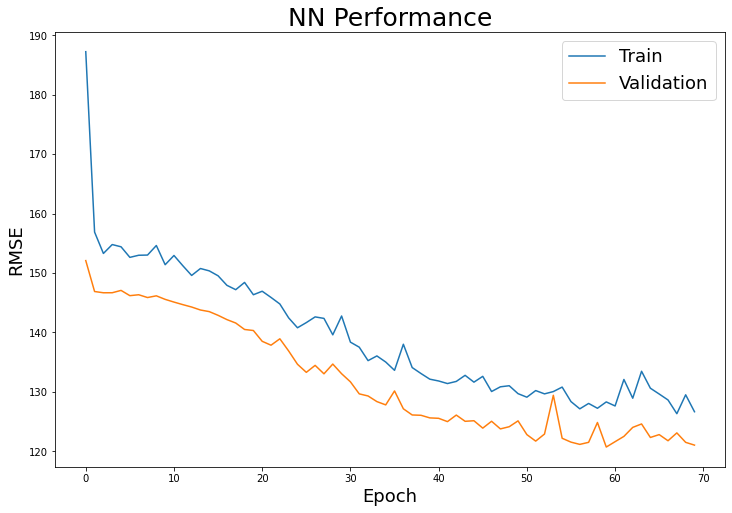

In [47]:
model = Sequential()

model.add(Dense(512, activation='relu', kernel_regularizer=l2(.0001))),
model.add(Dropout(.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(.0001))),
model.add(Dropout(.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(.0001))),
model.add(Dropout(.4))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError() )

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=100,
    callbacks=EarlyStopping(
        patience=10, 
        monitor='val_root_mean_squared_error', 
        min_delta=.0000001
    )
)

plot_hist(history)

A NN did not perform well, looking into other options.

## XGBoost

In [48]:
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [49]:
xgb = XGBRegressor(
    n_estimators=75, 
    max_depth=9,
    learning_rate=0.05,
    reg_alpha=100,
    reg_lambda=.1,
    subsample=.8,
    random_state=123,
    eval_metric='rmse',
    tree_method='gpu_hist', 
    gpu_id=0
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print('Train Score: ', xgb.score(X_train, y_train))
print(' Test Score: ', xgb.score(X_test, y_test))
print(mean_squared_error(y_test, xgb_preds, squared=False))


Train Score:  0.7816801264713015
 Test Score:  0.7822130948812217
70.86943613336547


This turned out to be my best model after a lot of tuning. I will use it in my production model.

In [50]:
y_test.mean()

161.9045837231057

## Alternative to Production Model Using 'date' as a Feature

This function fills in the missing dates

In [51]:
# create a period range for the whole dataset
idx = pd.period_range('2017-01-01', '2021-12-31', freq='M')

# Function that fills in missing dates
# Some stores didn't order product every month, so this will fill the quantity with a 0 for that month
# The function takes in a dataframe of one the controlled product labels from above (casa_linda, asti, etc.)
# returns a complete dataframe with the missing dates filled
def fill_missing_dates(data):

    df = data.copy()

    # empty list that will be filled with dataframes
    df_list = []
    
    # resets datetime index to 'date' column
    df.reset_index(inplace=True)
    # groups the dataframe by the date and store name
    df_gby = df.groupby(by=['date', 'sold_to_name'], as_index=False).sum()
    df_gby = df_gby.set_index('date')

    # loops over all the stores that purchased the product 
    for store in set(df_gby['sold_to_name']):

        temp = df_gby[df_gby['sold_to_name'] == store]          # filters the dataframe by the store
        temp.index = temp.index.to_period('M')                  # sets the period to 'M' for month
        temp = temp.reindex(idx, fill_value=0)                  # reindexes the dataframe with the full period range, fills blanks with 0's
        temp['sold_to_name'].replace(0, store, inplace=True)    # replace store names that were just filled with a 0 to the correct store name

        # append this store's dataframe to the df_list
        df_list.append(temp)

    # combines the individual store dataframes back into one dataframe and returns it
    return pd.concat(df_list)

helper function for adding dates to the RFM table, used for making predictions

In [52]:
def add_dates(df):

    df_target_stores = df.copy()

    df_list = []

    for store in set(df_target_stores["sold_to_name"]):

        df_store = df_target_stores[df_target_stores["sold_to_name"] == store]
        temp = df_store.copy()

        df_store = df_store.reindex(idx, fill_value=0)
        df_store["sold_to_name"].replace(0, store, inplace=True)

        df_store["recency"].replace(0, temp["recency"].values[0], inplace=True)
        df_store["frequency"].replace(0, temp["frequency"].values[0], inplace=True)
        df_store["monetary"].replace(0, temp["monetary"].values[0], inplace=True)
        df_store["r_quartile"].replace(0, temp["r_quartile"].values[0], inplace=True)
        df_store["f_quartile"].replace(0, temp["f_quartile"].values[0], inplace=True)
        df_store["m_quartile"].replace(0, temp["m_quartile"].values[0], inplace=True)
        df_store["rfm_segment"].replace(0, temp["rfm_segment"].values[0], inplace=True)
        df_store["rfm_score"].replace(0, temp["rfm_score"].values[0], inplace=True)
        df_store["labels3"].replace(0, temp["labels3"].values[0], inplace=True)

        df_list.append(df_store)

    df = pd.concat(df_list)

    df.index = df.index.to_timestamp()
    df.index.rename("date", inplace=True)
    df.reset_index(inplace=True)
    df["date"] = (df["date"] - dt.datetime(1970, 1, 1)).dt.total_seconds()

    return df

This function is very similar to the one used in the production model, but has the date included

In [53]:
def xgb_with_date_func(df):

    df_product = df.copy()

    df_product.index = df_product.index.to_timestamp()

    df_product.index.rename("date", inplace=True)
    df_product.reset_index(inplace=True)
    df_product = df_product.groupby(by=["date", "sold_to_name"], as_index=False)[
        ["quantity"]
    ].sum()

    df_model = pd.merge(rfm, df_product, on="sold_to_name")
    df_model["monetary_log"] = np.log(df_model["monetary"])
    df_model["date"] = (df_model["date"] - dt.datetime(1970, 1, 1)).dt.total_seconds()

    model_cols = [
        "recency",
        "frequency",
        "monetary",
        # 'monetary_log',
        "r_quartile",
        "f_quartile",
        "m_quartile",
        "rfm_score",
        "date",
        "quantity",
    ]

    df_model = df_model[model_cols]

    X = df_model.drop(columns=["quantity"])
    y = df_model["quantity"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

    xgb = XGBRegressor(
        n_estimators=75,
        max_depth=25,
        learning_rate=0.1,
        reg_alpha=100,
        reg_lambda=0.1,
        subsample=0.8,
        random_state=123,
        eval_metric="rmse",
        tree_method="gpu_hist",
        gpu_id=0,
    )

    tt = TransformedTargetRegressor(xgb, func=np.sqrt, inverse_func=np.square)
    tt.fit(X_train, y_train)

    # xgb.fit(X_train, y_train)

    tt_preds = tt.predict(X_test)
    # xgb_preds = xgb.predict(X_test)

    # print out scores
    print("  Train Score: ", tt.score(X_train, y_train))
    print("   Test Score: ", tt.score(X_test, y_test))
    print("")
    print("Baseline RMSE: ", y_train.mean())
    print("         RMSE: ", mean_squared_error(y_test, tt_preds, squared=False))

    df_product_stores = set(df_product["sold_to_name"])
    target_stores = rfm_stores[
        rfm_stores["sold_to_name"].isin(df_product_stores) == False
    ]
    target_stores = add_dates(target_stores)
    
    df_model_target = target_stores[
        [
            "recency",
            "frequency",
            "monetary",
            # 'monetary_log'
            "r_quartile",
            "f_quartile",
            "m_quartile",
            "rfm_score",
            "date",
        ]
    ]

    target_preds = tt.predict(df_model_target)
    target_stores['preds'] = target_preds

    return target_stores.sort_values(by='preds', ascending=False)



# turned off warning
pd.set_option('mode.chained_assignment', None)

In [54]:
xgb_with_date_func(fill_missing_dates(morenita))

  Train Score:  0.8104584677679375
   Test Score:  0.7906914236230062

Baseline RMSE:  94.90985663082438
         RMSE:  66.5263589600639


,date,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds
1553,1.622506e+09,Monterey Foods Market,0.000000,60,119379.00,1,2,1,121,4,0,0.0,0,454.084198
7676,1.630454e+09,Stinson Beach Market,0.000000,60,133639.92,1,2,1,121,4,0,0.0,0,454.084198
7675,1.627776e+09,Stinson Beach Market,0.000000,60,133639.92,1,2,1,121,4,0,0.0,0,454.084198
7674,1.625098e+09,Stinson Beach Market,0.000000,60,133639.92,1,2,1,121,4,0,0.0,0,454.084198
1556,1.630454e+09,Monterey Foods Market,0.000000,60,119379.00,1,2,1,121,4,0,0.0,0,454.084198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,1.575158e+09,SRJC Bookstore,57.866667,3,822.41,4,4,3,443,11,2,0.0,0,0.000885
3034,1.572566e+09,SRJC Bookstore,57.866667,3,822.41,4,4,3,443,11,2,0.0,0,0.000885
3033,1.569888e+09,SRJC Bookstore,57.866667,3,822.41,4,4,3,443,11,2,0.0,0,0.000885
3040,1.588291e+09,SRJC Bookstore,57.866667,3,822.41,4,4,3,443,11,2,0.0,0,0.000763


# Top Products (Not Controlled)

creating masks for the controlled products to remove from the data

In [55]:
cl_mask = products['item_description'].str.contains('Casa Linda') == False
fb_mask = products['item_description'].str.contains('Flatbread') == False
bert_mask = products['item_description'].str.contains('Bertolino') == False
asti_mask = products['item_description'].str.contains('Asti') == False
long_mask = products['item_description'].str.contains('Longitude') == False
lm_mask = products['item_description'].str.contains('La Morenita') == False
bd_mask = products['item_description'].str.contains("Baker's Delight") == False

removing controlled products

In [56]:
not_controlled = products[
    cl_mask &
    fb_mask & 
    bert_mask & 
    asti_mask & 
    long_mask & 
    lm_mask &
    bd_mask
]

not_controlled.head()

,territory,sold_to_name,item_description,item_type,standard_price,quantity,price,label
date,,,,,,,,
2017-01-01,EB,Monterey Foods Market,Have'a Corn Chips,CHIPS,1.90,48.0,76.80,0.0
2017-01-01,SF,Madera Liquor,Have'a Corn Chips,CHIPS,1.90,12.0,19.20,1.0
2017-01-01,SF,KD's Grog & Grocery,Benzels Pennystick Rods,CHIPS,1.81,6.0,10.86,2.0
2017-01-01,SF,KD's Grog & Grocery,Have'a Corn Chips,CHIPS,1.90,6.0,9.60,2.0
2017-01-01,SF,Fulton & Brodrick,Loacker Kakao Cookies,COOKIE,3.95,4.0,14.28,1.0


In [57]:
not_controlled['item_description'].value_counts().head(25)

Have'a Corn Chips                 3054
Roberts Pirates Booty-4 oz        2019
Benzels Thins-8 oz                1988
Wiley Wallaby Red - 10 oz         1883
Wiley Wallaby Black - 10 oz       1859
Sonoma Ranches BBQ Original       1686
Barbaras Cheese Puffs             1565
Nat Foods Org Coconut Milk        1426
Benzels Pennystick Rods           1377
Bariani EV Olive Oil - 16 oz      1369
Cafe Fanny Original               1328
Barbaras Jalapeno Cheese Puff     1327
Daily Crave Veggie Chips-6 oz     1309
Burton's Digestives               1292
Dolcetto Olive Oil & SS Crisps    1250
Krave Teriyaki Pork               1245
MTG Demi-Glace Gold               1243
Andy's Rub - 7 oz                 1242
Barbaras Cheese Puff Bakes        1231
Taco Works Orig - 11 oz           1191
El Sabroso Guacachip              1181
Haribo Gold Bears                 1178
Tahoe Sea Salt - 5 oz             1152
Barbaras White Cheddar Baked P    1127
Claeys Lemon                      1089
Name: item_description, d

### Finding the stores to sell to for the top products

## Have'a

In [58]:
not_controlled[not_controlled['item_description'].str.contains("Have'a")]['item_description'].value_counts()

Have'a Corn Chips    3054
Name: item_description, dtype: int64

In [59]:
have_a = not_controlled[not_controlled['item_description'].str.contains("Have'a")]

In [60]:
xgb_func(have_a, 'have_a')

  Train Score:  0.6699091905336843
   Test Score:  0.6256356110909929

Baseline RMSE:  47.40196479738027
         RMSE:  31.529032915936487


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
191,Mollie Stone #4-Greenbrae,0.000000,60,57271.328,1,2,1,121,4,0,10.955555,MR,95.872559,2.05
100,Fairfax Market,0.000000,60,56737.810,1,2,1,121,4,0,10.946196,MR,95.872559,2.05
104,Farmer Joe's - Fruitvale Ave.,0.000000,60,130840.370,1,2,1,121,4,0,11.781733,EB,94.131111,2.05
396,Zanottos - Naglee,0.000000,39,56315.340,1,2,1,121,4,0,10.938722,PN,86.564026,2.05
244,Piazza Fine Foods-San Mateo,0.000000,60,40862.280,1,2,1,121,4,0,10.617963,PN,80.519890,2.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,Woodlands Meat #2 Tiburon,0.000000,53,1536.060,1,2,3,123,6,0,7.336976,MR,9.910606,2.05
121,Georges Market,59.833333,1,147.570,4,4,4,444,12,2,4.994303,SF,4.789656,2.05
14,Andronico's #6-Los Altos,59.833333,1,81.840,4,4,4,444,12,2,4.404766,PN,4.789656,2.05
13,Andronico's #3-San Francisco,59.833333,1,291.752,4,4,4,444,12,2,5.675904,SF,4.789656,2.05


## Roberts Pirates Booty

In [61]:
not_controlled[not_controlled['item_description'].str.contains("Pirate")]['item_description'].value_counts()

Roberts Pirates Booty-4 oz        2019
Roberts Pirates Treasures-4 oz     206
Name: item_description, dtype: int64

In [62]:
pirate = not_controlled[not_controlled['item_description'].str.contains("Pirate")]

In [63]:
xgb_func(pirate, 'roberts_pirate_booty')

  Train Score:  0.49655592094898615
   Test Score:  0.4567052099246055

Baseline RMSE:  18.79473039215686
         RMSE:  12.574336072082911


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
220,Oceana Market,0.000000,60,63740.600,1,2,1,121,4,0,11.062577,PN,27.785215,2.36
242,Petaluma Market,0.000000,60,80595.188,1,2,1,121,4,0,11.297194,SN,27.785215,2.36
92,Draeger's-Menlo Park,0.000000,60,64383.500,1,2,1,121,4,0,11.072613,PN,27.785215,2.36
67,Cal Mart-Calistoga,0.000000,60,74357.500,1,2,1,121,4,0,11.216640,NP,27.785215,2.36
66,Cal Mart -San Francisco,0.000000,60,91380.690,1,2,1,121,4,0,11.422789,SF,27.785215,2.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Eureka Mkt. - S.F.,52.766667,1,130.740,4,4,4,444,12,2,4.873211,SF,3.601483,2.36
156,KD's Grog & Grocery,59.833333,1,68.760,4,4,4,444,12,2,4.230622,SF,3.601483,2.36
153,Jules Thin Crust-Danville,39.566667,1,68.800,4,4,4,444,12,2,4.231204,EB,3.601483,2.36
121,Georges Market,59.833333,1,147.570,4,4,4,444,12,2,4.994303,SF,3.601483,2.36


## Benzel

In [64]:
not_controlled[not_controlled['item_description'].str.contains("Benzel")]['item_description'].value_counts()

Benzels Thins-8 oz            1988
Benzels Pennystick Rods       1377
Benzels Honey Wheat Braid     1031
Benzel Sticks                  166
Benzel Minis                   103
Benzels Oat Bran Nuggets        80
Benzels Multigrain Nuggets      65
Name: item_description, dtype: int64

In [65]:
benzel = not_controlled[not_controlled['item_description'].str.contains("Benzel")]

In [66]:
xgb_func(benzel, 'benzel')

  Train Score:  0.3005031146536946
   Test Score:  0.2970163581243328

Baseline RMSE:  21.639921722113503
         RMSE:  15.731892248539612


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
242,Petaluma Market,0.000000,60,80595.188,1,2,1,121,4,0,11.297194,SN,30.531885,1.81
47,Brown's Valley Mkt.,0.000000,60,70057.180,1,2,1,121,4,0,11.157067,NP,30.531885,1.81
343,Surf Super,0.000000,60,97365.780,1,2,1,121,4,0,11.486230,MN,30.531885,1.81
36,Big John's Market,0.000000,60,71090.520,1,2,1,121,4,0,11.171709,SN,30.531885,1.81
66,Cal Mart -San Francisco,0.000000,60,91380.690,1,2,1,121,4,0,11.422789,SF,30.531885,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,Jules Thin Crust-Danville,39.566667,1,68.800,4,4,4,444,12,2,4.231204,EB,5.929496,1.81
267,Rosenberg's,58.800000,1,56.620,4,4,4,444,12,2,4.036362,SF,5.929496,1.81
159,Kim's Baskets,19.300000,1,30.370,3,4,4,344,11,2,3.413455,SN,5.929496,1.81
387,Woodlands #2/Tib. - Drop Ship,43.666667,1,19.560,4,4,4,444,12,2,2.973487,MR,5.929496,1.81


## Wiley Wallaby

In [67]:
not_controlled[not_controlled['item_description'].str.contains("Wiley")]['item_description'].value_counts()

Wiley Wallaby Red - 10 oz         1883
Wiley Wallaby Black - 10 oz       1859
Wiley Wallaby Grn Apple - 10 o     943
Wiley Wallaby Watermelon - 10      865
Wiley Wallaby Black - 7 oz         367
Wiley Wallaby Red - 7 oz           350
Wiley Wallaby Org Black Bites      213
Wiley Wallaby Org Strawb Bites     198
Wiley Wallaby Red-Tub              158
Wiley Wallaby Blk-Tub              155
Wiley Wallaby Org Berry Bites      152
Wiley Wallaby Blk Beans - 7 oz     122
Wiley Wallaby Allsorts - 6 oz      112
Wiley Wallaby Grn Apple - 7 oz     106
Wiley Wallaby Huckleberry - 7       92
Wiley Wallaby Red 2 oz              77
Wiley Wallaby Org Tropical Bit      75
Wiley Wallaby Black 2 oz            60
Wiley Wallaby Red Beans - 7 oz      48
Wiley Wallaby Funsorts - 6 oz       45
Wiley Wallaby Blueb Pom - 10 o      37
Wiley Wallaby Blueberry - 10 o      36
Wiley Wallaby Blasted Berry -       25
Name: item_description, dtype: int64

In [68]:
wiley = not_controlled[not_controlled['item_description'].str.contains("Wiley")]

In [69]:
xgb_func(wiley, 'wiley_wallaby')

  Train Score:  0.06348406154653152
   Test Score:  0.03938277499952492

Baseline RMSE:  26.930851063829788
         RMSE:  22.392968049681194


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
336,Stinson Beach Market,0.000000,60,133639.920,1,2,1,121,4,0,11.802904,MR,29.589882,3.39
341,Sunshine Mkt. - St. Helena,0.000000,60,144537.310,1,2,1,121,4,0,11.881293,NP,29.589882,3.39
242,Petaluma Market,0.000000,60,80595.188,1,2,1,121,4,0,11.297194,SN,27.555420,3.39
237,Pelican Plaza Grocery & Deli,0.000000,60,100101.410,1,2,1,121,4,0,11.513939,MN,27.024677,3.39
223,Oliver's Market-Cotati,0.000000,60,107963.996,1,2,1,121,4,0,11.589553,SN,27.024677,3.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,Star Ell Market,54.800000,4,289.470,4,4,4,444,12,2,5.668052,SF,4.008206,3.39
332,Stand-Bi Market,50.733333,4,351.710,4,4,4,444,12,2,5.862807,SF,4.008206,3.39
117,Fulton Foods,50.733333,4,177.580,4,4,4,444,12,2,5.179421,SF,4.008206,3.39
135,Haight & Central,57.866667,3,146.530,4,4,4,444,12,2,4.987230,SF,4.008206,3.39


## Sonoma Ranches

In [70]:
not_controlled[not_controlled['item_description'].str.contains("Sonoma Ranches")]['item_description'].value_counts()

Sonoma Ranches BBQ Original       1686
Sonoma Ranches BBQ Spicy           868
Sonoma Ranches Steak Sauce         608
Sonoma Ranches Teriyaki Marina     550
Sonoma Ranches BBQ Gallon           75
Sonoma Ranches Teriyaki Gallon      53
Name: item_description, dtype: int64

In [71]:
sn_ranches = not_controlled[not_controlled['item_description'].str.contains("Sonoma Ranches")]

In [72]:
xgb_func(sn_ranches, 'sn_ranches')

  Train Score:  0.19244643074098577
   Test Score:  0.28293878491209024

Baseline RMSE:  14.758101851851851
         RMSE:  10.21351602511014


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
47,Brown's Valley Mkt.,0.000000,60,70057.18,1,2,1,121,4,0,11.157067,NP,14.688526,3.48
67,Cal Mart-Calistoga,0.000000,60,74357.50,1,2,1,121,4,0,11.216640,NP,14.688526,3.48
18,Andy's Produce - Sebastopol,0.000000,60,73283.37,1,2,1,121,4,0,11.202089,SN,14.688526,3.48
341,Sunshine Mkt. - St. Helena,0.000000,60,144537.31,1,2,1,121,4,0,11.881293,NP,12.979449,3.48
34,Bianchini's Mkt - Alpine Rd.,0.000000,60,86441.88,1,2,1,121,4,0,11.367228,PN,12.966781,3.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,Rosenberg's,58.800000,1,56.62,4,4,4,444,12,2,4.036362,SF,3.510626,3.48
268,Roxie Market & Deli,57.866667,3,219.88,4,4,4,444,12,2,5.393082,SF,3.510626,3.48
95,Driver's Mkt - Sausalito,58.800000,2,139.14,4,4,4,444,12,2,4.935481,MR,3.510626,3.48
271,SRJC Bookstore,57.866667,3,822.41,4,4,3,443,11,2,6.712239,SN,3.510626,3.48


## Barbaras Cheese Puffs

In [73]:
not_controlled[not_controlled['item_description'].str.contains("Cheese Puff")]['item_description'].value_counts()

Barbaras Cheese Puffs            1565
Barbaras Jalapeno Cheese Puff    1327
Barbaras Cheese Puff Bakes       1231
Name: item_description, dtype: int64

In [74]:
cheese_puffs = not_controlled[not_controlled['item_description'].str.contains("Cheese Puff")]

In [75]:
xgb_func(cheese_puffs, 'barb_cheese_puffs')

  Train Score:  0.5305770452475891
   Test Score:  0.566706971116443

Baseline RMSE:  27.266031746031747
         RMSE:  20.610434199782624


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
341,Sunshine Mkt. - St. Helena,0.000000,60,144537.310,1,2,1,121,4,0,11.881293,NP,62.626492,2.8
188,Mill Valley Market,0.000000,60,34103.096,1,2,1,121,4,0,10.437143,MR,34.741371,2.8
193,Mollie Stone #6-Burlingame,0.000000,60,39331.140,1,2,1,121,4,0,10.579772,PN,34.741371,2.8
189,Mollie Stone #1-Sausalito,0.000000,60,32757.950,1,2,1,121,4,0,10.396901,MR,34.741371,2.8
86,Delucchi's Market,0.000000,60,42400.740,1,2,1,121,4,0,10.654921,PN,34.741371,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Liquid Experience,58.800000,1,65.500,4,4,4,444,12,2,4.182050,SF,6.717284,2.8
14,Andronico's #6-Los Altos,59.833333,1,81.840,4,4,4,444,12,2,4.404766,PN,6.717284,2.8
156,KD's Grog & Grocery,59.833333,1,68.760,4,4,4,444,12,2,4.230622,SF,6.717284,2.8
267,Rosenberg's,58.800000,1,56.620,4,4,4,444,12,2,4.036362,SF,6.717284,2.8


## Andy's Rub

In [76]:
not_controlled[not_controlled['item_description'].str.contains("Andy")]['item_description'].value_counts()

Andy's Rub - 7 oz         1242
Andy's Rub Bag - 5 lbs     147
Andy's Rub - 11 oz          45
Name: item_description, dtype: int64

In [77]:
andy = not_controlled[not_controlled['item_description'].str.contains("Andy")]

In [78]:
xgb_func(andy, "andys_rub")

  Train Score:  0.047137364646046565
   Test Score:  0.05361468329313979

Baseline RMSE:  12.160591133004926
         RMSE:  8.353659346877091


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
67,Cal Mart-Calistoga,0.000000,60,74357.50,1,2,1,121,4,0,11.216640,NP,11.896924,6.12
66,Cal Mart -San Francisco,0.000000,60,91380.69,1,2,1,121,4,0,11.422789,SF,11.896924,6.12
47,Brown's Valley Mkt.,0.000000,60,70057.18,1,2,1,121,4,0,11.157067,NP,11.896924,6.12
237,Pelican Plaza Grocery & Deli,0.000000,60,100101.41,1,2,1,121,4,0,11.513939,MN,11.896924,6.12
341,Sunshine Mkt. - St. Helena,0.000000,60,144537.31,1,2,1,121,4,0,11.881293,NP,10.210167,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Haight & Central,57.866667,3,146.53,4,4,4,444,12,2,4.987230,SF,4.881454,6.12
137,Haight & Victoria,41.633333,1,66.45,4,4,4,444,12,2,4.196450,SF,4.881454,6.12
247,Puerto Vallerta Market,38.566667,4,131.16,4,4,4,444,12,2,4.876418,NP,4.881454,6.12
245,Point Richmond Mkt.,46.633333,1,35.21,4,4,4,444,12,2,3.561330,EB,4.881454,6.12


## Off the Farm

In [79]:
not_controlled[not_controlled['item_description'].str.contains("Off The Farm")]['item_description'].value_counts()

Off The Farm Wild Blueb Van       233
Off The Farm Mango Coconut Cas    195
Off The Farm Dk Choc Fudge        156
Off The Farm Banana Walnut Dat    156
Off The Farm PB Choc Protein      125
Off The Farm Cocoa Coconut Mac    120
Off The Farm Apple Cinn Pecan     109
Off The Farm Wild Blueberry        85
Off The Farm Granny's Gingerbr     83
Off The Farm Lemon Cream Pie       56
Off The Farm Dk Choc               52
Off The Farm Apple Cinn            43
Off The Farm Gingerbread           26
Off The Farm PB Choc               23
Off The Farm Strawberry Coconu     19
Off The Farm Cherry Choc GF Ve      7
Off The Farm Pumpkin Pie            6
Name: item_description, dtype: int64

In [80]:
off_the_farm = not_controlled[not_controlled['item_description'].str.contains("Off The Farm")]

In [81]:
xgb_func(off_the_farm, 'off_the_farm')

  Train Score:  -0.11334253775376357
   Test Score:  -0.2679892973254425

Baseline RMSE:  3.5651214128035322
         RMSE:  3.067876176212376


,sold_to_name,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_segment,rfm_score,labels3,monetary_log,territory,preds,standard_price
188,Mill Valley Market,0.000000,60,34103.096,1,2,1,121,4,0,10.437143,MR,2.038983,24.84
224,Oliver's Market-Montecito Blvd,0.000000,60,101797.972,1,2,1,121,4,0,11.530745,SN,2.038983,24.84
104,Farmer Joe's - Fruitvale Ave.,0.000000,60,130840.370,1,2,1,121,4,0,11.781733,EB,2.038983,24.84
226,Oliver's- Windsor,0.000000,60,69801.100,1,2,1,121,4,0,11.153405,SN,2.038983,24.84
228,Oliver's-Stony Point Rd.,0.000000,60,106693.476,1,2,1,121,4,0,11.577715,SN,2.038983,24.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Ranch Market,0.000000,6,667.590,1,3,3,133,7,1,6.503674,NP,1.782906,24.84
148,Jacks Valley Store,1.000000,33,2422.010,2,3,3,233,8,1,7.792353,SN,1.782906,24.84
247,Puerto Vallerta Market,38.566667,4,131.160,4,4,4,444,12,2,4.876418,NP,1.782906,24.84
245,Point Richmond Mkt.,46.633333,1,35.210,4,4,4,444,12,2,3.561330,EB,1.782906,24.84


# Export to Excel

In [82]:
files = os.listdir('../data/recommendations')

writer = pd.ExcelWriter('../data/final_recommendations.xlsx')
for file in files:
    df = pd.read_csv(f'../data/recommendations/{file}', compression='zip')
    df.to_excel(writer, sheet_name=file.split('.')[0], index=False)
writer.save()

# Estimating Profits

In [83]:
profits = []

for file in files:
    df = pd.read_csv(f'../data/recommendations/{file}', compression='zip')
    df_temp = df[['preds', 'standard_price']][:3]
    df_temp['profits'] = ((df_temp['preds'] * df_temp['standard_price']) * .3) * 12
    profits.append(df_temp['profits'].sum())

In [84]:
sum(profits)

26200.711270519198